In [8]:
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout,Input

In [9]:
IMAGE_SIZE = 256
BATCH_SIZE = 64
CHANNELS = 3


In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
     "C:/Users/user/OneDrive/Documents/SKIN CANCER/multiple-skin-disease-detection-and-classification/Skin Cancer Dataset",
    shuffle=True,   # to randomly shuffle the images
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4107 files belonging to 9 classes.


In [12]:
class_names = dataset.class_names
class_names

['Acitinic Keratosis',
 'Basal Cell Carcinoma',
 'Dermatofibroma',
 'Melanoma',
 'Nevus',
 'Pigmented Benign Keratosis',
 'Seborrheic Keratosis',
 'Squamous Cell Carcinoma',
 'Vascular Lesion']

In [13]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(64, 256, 256, 3)
[0 0 8 6 7 5 6 6 3 5 4 5 0 3 4 5 8 5 2 2 2 4 4 2 3 5 6 1 1 0 2 5 3 3 5 2 2
 6 1 5 2 6 3 6 6 1 5 8 2 8 7 5 7 2 7 3 5 0 4 6 0 0 2 7]


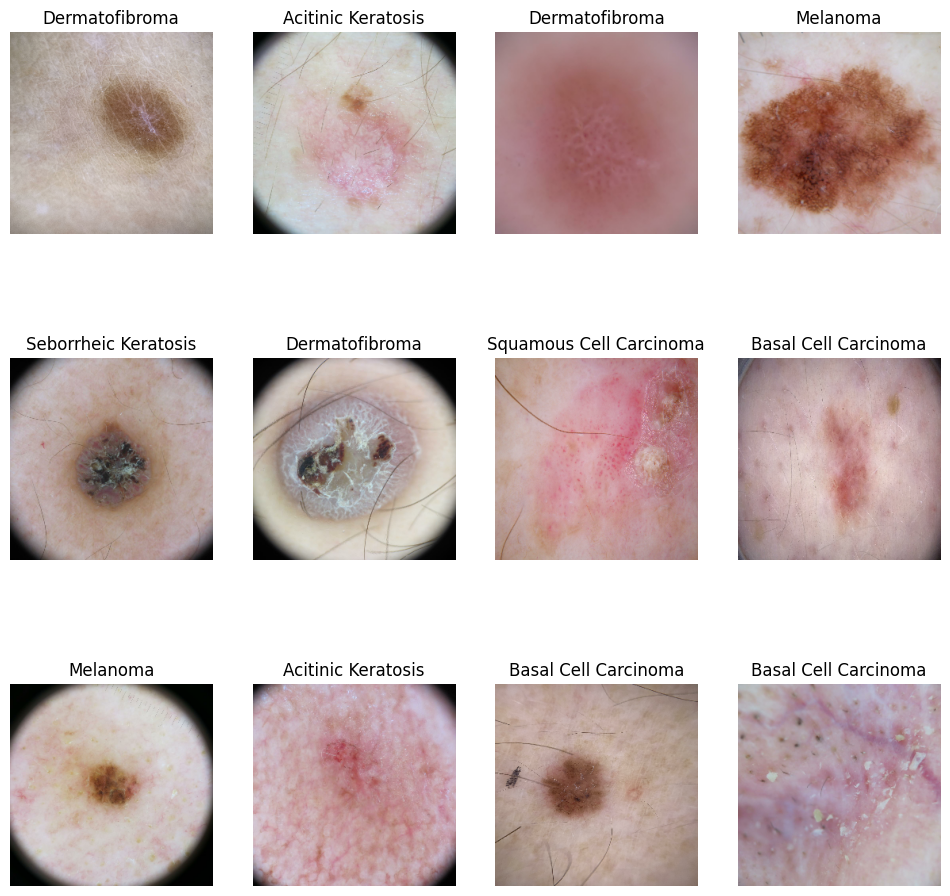

In [14]:
plt.figure(figsize=(12,12))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [15]:
# spliting he dataset using a function
def get_datset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle= True, shuffle_size=10000):
    ds_size= len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size= int(train_split* ds_size)
    val_size=int(val_split * ds_size)
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)

    return train_ds, val_ds,test_ds

In [16]:
train_ds, val_ds,test_ds = get_datset_partitions_tf(dataset)

In [17]:
len(train_ds), len(val_ds), len(test_ds)

(52, 6, 7)

In [18]:
#train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE))),
    tf.keras.layers.Rescaling(1.0/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
   layers.RandomFlip("horizontal" or "vertical"),
   layers.RandomRotation(0.2),
   layers.RandomZoom(0.2),
   #layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  
#    layers.RandomContrast(factor=0.1),              # Adjusts contrast randomly by up to 10%
#    layers.RandomBrightness(factor=0.1) 
])

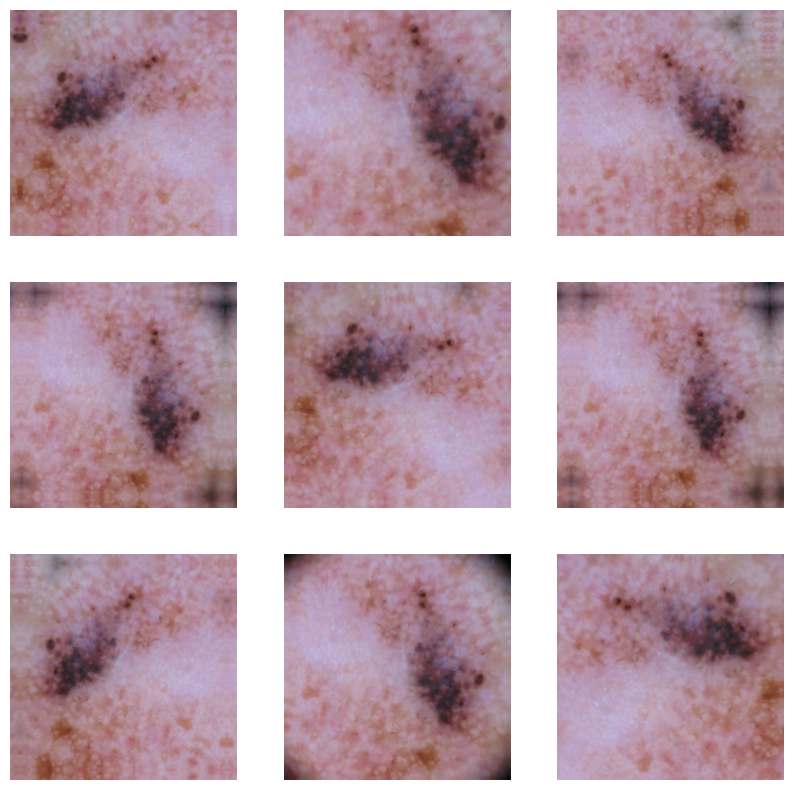

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(3):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [22]:
# from tensorflow.keras.applications import VGG16 
from tensorflow.keras.applications import EfficientNetB0
# Load pre-trained model 
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  

# Add custom layers for fine-tuning
inputs = Input(shape=(256,256, 3))
x=resize_and_rescale(inputs)
x = data_augmentation(inputs)
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
x = Dropout(0.5)(x)  
predictions = Dense(9, activation='softmax')(x)  

# Create the final fine-tuned model
model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
from keras import optimizers
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.9, beta_2=0.999),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [24]:
from tensorflow.keras.callbacks import Callback,EarlyStopping
# # Define a custom callback to stop when validation accuracy reaches 0.90 and training accuracy reaches 0.90
# class StopAtValAccuracy(Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         val_accuracy = logs.get('val_accuracy')
#         accuracy = logs.get('accuracy')
#         if val_accuracy is not None and val_accuracy >= 0.85 and accuracy is not None and accuracy >= 0.85:
#             print(f"\nReached {val_accuracy*100:.2f}% val_accuracy and {accuracy*100:.2f}% accuracy, stopping training!")
#             self.model.stop_training = True

# # Instantiate the custom callback
# stop_at_val_accuracy = StopAtValAccuracy()
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                           mode='auto', restore_best_weights=True)

In [25]:
history = model.fit(
    train_ds,
    epochs=25,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
#     callbacks=[early_stop]

)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 314s 6s/step - accuracy: 0.3242 - loss: 2.2676 - val_accuracy: 0.6380 - val_loss: 1.0877
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 365s 7s/step - accuracy: 0.6774 - loss: 0.9366 - val_accuracy: 0.7188 - val_loss: 0.8498
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 415s 8s/step - accuracy: 0.7696 - loss: 0.6868 - val_accuracy: 0.7526 - val_loss: 0.7109
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 412s 8s/step - accuracy: 0.8006 - loss: 0.5706 - val_accuracy: 0.7656 - val_loss: 0.6743
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 288s 6s/step - accuracy: 0.8561 - loss: 0.4181 - val_accuracy: 0.7865 - val_loss: 0.6235
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 376s 7s/step - accuracy: 0.8985 - loss: 0.3253 - val_accuracy: 0.8359 - val_loss: 0.5284
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 357s 7s/step - accuracy: 0.9127 - loss: 0.2666 - val_accuracy: 0.8307 - val_loss: 0.5376
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1083s 21s/step - accuracy: 0.9297 - loss: 0.2339 - val_accuracy: 0.8672 -

In [31]:
#model.evaluate(test_ds)

## evaluation

In [27]:
import numpy as np
y_pred = []
y_true = []

for image_batch, label_batch in test_ds:
    predictions = model.predict(image_batch)
    predicted_labels = np.argmax(predictions, axis=-1)
    y_pred.extend(predicted_labels)
    y_true.extend(label_batch.numpy())


2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step


In [28]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Print shapes to verify
print("Predicted labels shape:", y_pred.shape)
print("True labels shape:", y_true.shape)


Predicted labels shape: (395,)
True labels shape: (395,)


In [29]:
from sklearn.metrics import classification_report, accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8531645569620253


In [30]:
# Print classification report
class_names = ["nevus", "melanoma", "squamous cell carcinoma", "basal cell carcinoma", "actinic keratosis", "vascular lesion", "dermatofibroma", "seborrheic keratosis", "pigmented benign keratosis"]
print(classification_report(y_true, y_pred, target_names=class_names))

                            precision    recall  f1-score   support

                     nevus       0.85      0.85      0.85        48
                  melanoma       0.76      0.81      0.78        47
   squamous cell carcinoma       0.95      0.89      0.92        45
      basal cell carcinoma       0.83      0.76      0.80        51
         actinic keratosis       0.94      0.92      0.93        48
           vascular lesion       0.84      0.89      0.86        46
            dermatofibroma       0.82      0.84      0.83        43
      seborrheic keratosis       0.85      0.87      0.86        39
pigmented benign keratosis       0.86      0.86      0.86        28

                  accuracy                           0.85       395
                 macro avg       0.85      0.85      0.85       395
              weighted avg       0.85      0.85      0.85       395



In [32]:
model.save('skin_cancer_model.keras')